In [2]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from hmmlearn import hmm
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [3]:
df = pd.read_csv('../data/metro_interstate_traffic_volume_processed.csv')

X = df.drop(columns=['traffic_volume', 'traffic_volume_category'])
y = df['traffic_volume_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [4]:
day_of_week_categories = ['weekday', 'weekend']
time_of_day_categories = df['time_of_day'].unique()
weather_categories = df['weather'].unique()
temp_categories = df['temp'].unique()
traffic_categories = df['traffic_volume_category'].unique()

observations = list(product(time_of_day_categories, weather_categories))
observations_map = {
    '_'.join(obs): i for i, obs in enumerate(observations)
}

state_map = {
    state: i for i, state in enumerate(traffic_categories)
}

In [5]:
def get_observation_index(row):
    obs = f"{row['time_of_day']}_{row['weather']}"
    return observations_map[obs]

def get_sequence(data):
    return data[['weekend', 'time_of_day', 'weather', 'temp']].apply(get_observation_index, axis=1).values.reshape(-1, 1)

In [6]:
model = hmm.CategoricalHMM(n_components=len(traffic_categories), n_iter=100, random_state=42)
model.n_features = len(observations)

train_sequence = get_sequence(X_train)
model.fit(train_sequence)

CategoricalHMM(n_components=4, n_features=20, n_iter=100,
               random_state=RandomState(MT19937) at 0x132EEC140)

In [7]:
print("Transition matrix:")
for row in model.transmat_:
    for prob in row:
        print(f"{prob:.2f}", end=' ')
    print()

print("\nEmission matrix:")
for row in model.emissionprob_:
    for prob in row:
        print(f"{prob:.2f}", end=' ')
    print()

Transition matrix:
0.84 0.00 0.16 0.00 
0.00 0.85 0.00 0.15 
0.00 0.16 0.84 0.00 
0.15 0.00 0.00 0.85 

Emission matrix:
0.00 0.00 0.00 0.00 0.00 0.42 0.24 0.12 0.14 0.07 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.25 0.31 0.12 0.17 0.16 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.34 0.30 0.13 0.14 0.09 0.00 0.00 0.00 0.00 0.00 
0.31 0.25 0.11 0.18 0.16 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 


In [8]:
test_sequence = get_sequence(X_test)
predicted = model.predict(test_sequence)
trues = y_test.apply(lambda x: state_map[x]).values

hmm_map = {
    1: 3,
    2: 2,
    3: 0,
    0: 1
}

predicted = [hmm_map[p] for p in predicted]

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=trues, mode='lines', name='True'))
fig.add_trace(go.Scatter(y=predicted, mode='lines', name='Predicted'))

fig.update_layout(
    title="Predicted vs True Values",
    xaxis_title="Index",
    yaxis_title="Value",
    legend=dict(x=0.02, y=0.98)
)
fig.show()


Accuracy: 0.58
F1: 0.58
[[1040 1294   38    0]
 [ 903  964  590    0]
 [ 422   95 1541  374]
 [ 120    0  197 2061]]


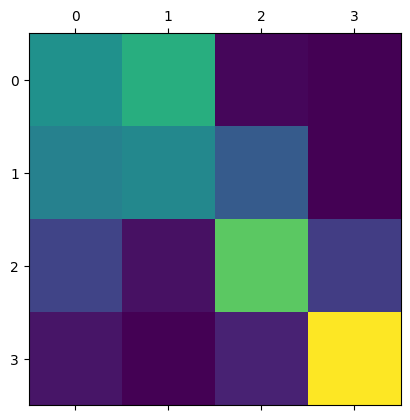

In [10]:
accuracy = accuracy_score(trues, predicted)
f1 = f1_score(trues, predicted, average='weighted')
print(f"Accuracy: {accuracy:.2f}")
print(f"F1: {f1:.2f}")

cm = confusion_matrix(trues, predicted)
plt.matshow(cm)
print(cm)